In [1]:
! pip install --quiet "ipython[notebook]>=8.0.0, <8.12.0" "torch>=1.8.1, <1.14.0" "setuptools==67.4.0" "torchmetrics>=0.7, <0.12" "torchvision" "pytorch-lightning>=1.4, <2.0.0" "lightning>=2.0.0rc0"
!pip install pytorch-lightning
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from torch.utils.data import DataLoader, random_split
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
import lightning as L

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=24
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.3/793.3 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 KB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
images = np.load("/content/gdrive/MyDrive/small_data.npy")
labels = np.genfromtxt('/content/gdrive/MyDrive/all_target.csv', delimiter=',')
labels = labels[1:]
label = np.zeros(81*10)
labels = np.array([1 if i < 3 else 0 for i in labels]) #1 - healthy | 0 - problems
for i in range(810):
  label[i] = labels[i//10]
label = label.astype(int,copy=False)
images = np.resize(images, (810, 512, 512))
train_images, test_images, train_labels, test_labels = train_test_split(images, label, test_size=0.2, random_state=42)

Mounted at /content/gdrive


In [66]:
import albumentations as A
import albumentations.pytorch


class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, transforms):
        self.images = train_images
        self.labels = train_labels
        self.transforms = transforms

    def __getitem__(self, idx):
        img = self.images[idx]
        img = img[130:430, 100:400]
        augmentations = self.transforms(image=img)
        image = augmentations["image"]
        return image, (self.labels[idx].astype(np.float32))

    def __len__(self):
        return self.images.shape[0]

class SegmentationTestDataset(torch.utils.data.Dataset):
    def __init__(self, transforms):
        self.images = test_images
        self.labels = test_labels
        self.transforms = transforms

    def __getitem__(self, idx):
        img = self.images[idx]
        img = img[130:430, 100:400]
        augmentations = self.transforms(image=img)
        image = augmentations["image"]
        return image, (self.labels[idx].astype(int))

    def __len__(self):
        return self.images.shape[0]

test_data = SegmentationTestDataset(
    transforms=A.Compose([A.Resize(height=128, width=128),A.Normalize((0.5,), (0.5,)), A.pytorch.transforms.ToTensorV2()]),
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=162, pin_memory=True, num_workers=2, shuffle = False
)
data = SegmentationDataset(
    transforms=A.Compose([A.Resize(height=128, width=128),A.Normalize((0.5,), (0.5,)), A.pytorch.transforms.ToTensorV2()]),
)

train_loader = torch.utils.data.DataLoader(
    dataset=data, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2, shuffle = True
)

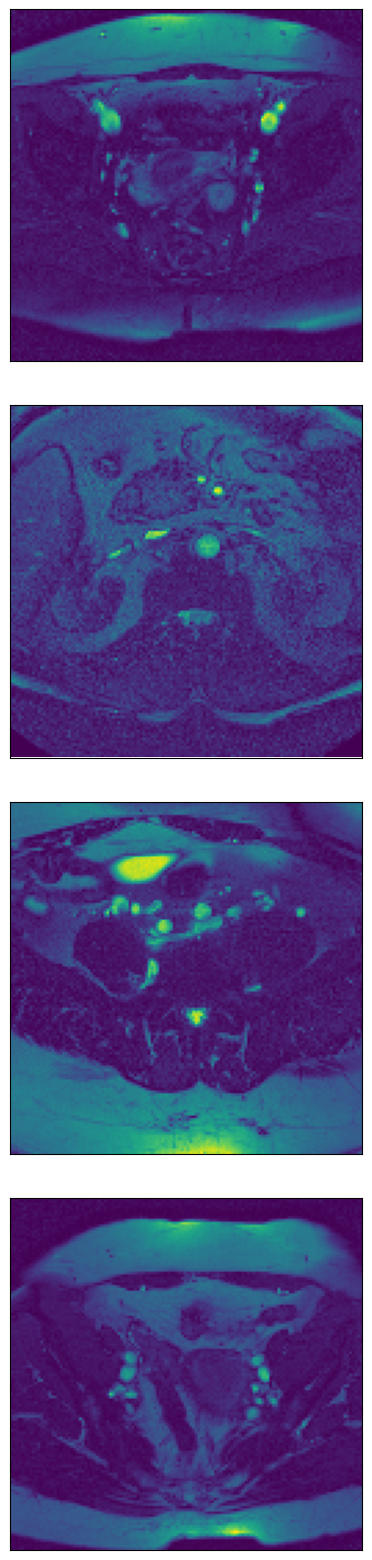

In [68]:
def im_show(img_list) -> None:

    fig, axes = plt.subplots(len(img_list), 1, figsize=(16, 16))
    fig.tight_layout()

    for (idx, sample) in enumerate(img_list):
        a = axes[idx].imshow(sample.squeeze())
        for ax in axes:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()


img_list = []
for i in range(4):
    img = data[i][0]
    img_list.append(img)

im_show(img_list)

In [69]:
discr_loss_trace = []
gen_loss_trace = []
test_acc = []
test_rec = []
test_pr = []

In [70]:
class Generator_cl(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape

        def block(in_ch, out_ch, kernel_size, stride, padding, normalize=True, relu = True):
            layers = [nn.ConvTranspose2d(in_channels = in_ch, out_channels = out_ch,
                                         kernel_size = kernel_size, stride = stride,
                                         padding = padding)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_ch, 0.8))
            if relu: 
              layers.append(nn.LeakyReLU(inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 512, 8, 2, 0),
            *block(512, 1024, 4, 3, 2),
            *block(1024, 256, 4, 3, 0),
            *block(256, 1, 4, 2, 1, False, False),
            nn.Tanh(),
        )

    def forward(self, z):
        inp = z.view(z.size(0), z.size(1), 1, 1)
        img = self.model(inp)
        return img

In [53]:
Generator_cl(100, (1, 128, 128)).eval()

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(8, 8), stride=(2, 2))
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): ConvTranspose2d(512, 1024, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2))
    (4): BatchNorm2d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(3, 3))
    (7): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)

In [71]:
class Discriminator_cl(nn.Module):
    def __init__(self, img_shape):
        super().__init__()

        def block(in_ch, out_ch, kernel_size, stride, padding, normalize=True, relu = True):
            layers = [nn.Conv2d(in_channels = in_ch, out_channels = out_ch,
                                         kernel_size = kernel_size, stride = stride,
                                         padding = padding)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_ch, 0.8))
            if relu: 
              layers.append(nn.LeakyReLU(inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(1, 64, 3, 2, 0),
            *block(64, 128, 3, 1, 0),
            *block(128, 1, 3, 1, 0),
            nn.Flatten(),
            nn.Linear(59*59, 50),
        )

        self.classif = nn.Sequential(
            nn.Linear(50, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 24),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(24, 1),
            nn.Sigmoid(),
        )

        self.end = nn.Sequential(
            nn.Linear(50, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 24),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(24, 1),
            nn.Sigmoid(),
        )

    def classifier_layers(self):
      return self.classif.parameters()

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        res = self.classif(validity)
        validity = self.end(validity)
        return [validity, res]

In [65]:
Discriminator_cl((1, 128, 128)).eval()

Discriminator_cl(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(1, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=3481, out_features=50, bias=True)
  )
  (classif): Sequential(
    (0): Linear(in_features=50, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=24, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=Tru

In [72]:
class GAN_cl(L.LightningModule):
    def __init__(
        self,
        channels,
        width,
        height,
        latent_dim: int = 100,
        lr: float = 0.0002,
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = BATCH_SIZE,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        data_shape = (channels, width, height)
        self.generator = Generator_cl(latent_dim=self.hparams.latent_dim, img_shape=data_shape)
        self.discriminator = Discriminator_cl(img_shape=data_shape)
        self.validation_z = torch.randn(8, self.hparams.latent_dim)
        self.example_input_array = torch.zeros(2, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch):
        imgs, labels = batch
        # initialize optimizers
        optimizer_g, optimizer_d, optimizer_c = self.optimizers()
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(imgs)

        self.toggle_optimizer(optimizer_g)
        # generate images
        self.generated_imgs = self(z)
        sample_imgs = self.generated_imgs[:6]
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, 0)
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)
        g_loss = self.adversarial_loss(self.discriminator(self(z))[0], valid)
        self.log("g_loss", g_loss, prog_bar=True)
        self.manual_backward(g_loss)
        optimizer_g.step()
        optimizer_g.zero_grad()
        self.untoggle_optimizer(optimizer_g)

        self.toggle_optimizer(optimizer_d)
        valid = torch.unsqueeze(labels, 1)
        valid = valid.type_as(imgs)
        real_loss = self.adversarial_loss(self.discriminator(imgs)[0], valid)
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)
        fake_loss = self.adversarial_loss(self.discriminator(self(z).detach())[0], fake)

         # discriminator loss is the average of these
        d_loss = (real_loss + fake_loss) / 2
        self.log("d_loss", d_loss, prog_bar=True)
        self.manual_backward(d_loss)
        optimizer_d.step()
        optimizer_d.zero_grad()
        self.untoggle_optimizer(optimizer_d)

        self.toggle_optimizer(optimizer_c)
        valid = torch.unsqueeze(labels, 1)
        valid = valid.type_as(imgs)
        real_loss = self.adversarial_loss(self.discriminator(imgs)[1], valid)
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)
        fake_loss = self.adversarial_loss(self.discriminator(self(z).detach())[1], fake)
        c_loss = (real_loss + fake_loss) / 2
        self.log("c_loss", c_loss, prog_bar=True)
        self.manual_backward(c_loss)
        optimizer_c.step()
        optimizer_c.zero_grad()
        self.untoggle_optimizer(optimizer_c)

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        opt_c = torch.optim.Adam(self.discriminator.classifier_layers(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d, opt_c],[]

    def on_validation_epoch_end(self):
        z = self.validation_z.type_as(self.generator.model[0].weight)
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

    def on_train_epoch_end(self):
      for valid_batch in test_loader:
        valid_objects, valid_labels = valid_batch
        valid_labels = torch.unsqueeze(valid_labels, 1)
        z = torch.normal(0, 1, (30, 100))
        gen_objects = self.generator(z)
        real_objects_scores = self.discriminator(valid_objects)[1]
        gen_objects_scores = self.discriminator(gen_objects)[1]
        y_pr = torch.cat([real_objects_scores, gen_objects_scores], 0)
        y_tr = torch.cat([valid_labels, torch.zeros((30, 1))], 0)
        y_pred = torch.squeeze(y_pr, 1).detach().numpy()
        y_true = torch.squeeze(y_tr, 1)
        y_pred = torch.tensor([0 if i < 0.5 else 1 for i in y_pred])
        acc = accuracy_score(y_pred, y_true)
        rec = recall_score(y_pred, y_true)
        pr = precision_score(y_pred, y_true)
        test_rec.append(rec)
        test_pr.append(pr)
        test_acc.append(acc)
        self.log("test_acc", acc, prog_bar=True)

In [73]:
dm = train_loader
model = GAN_cl(1, 128, 128)
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=200,
)
trainer.fit(model, dm)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type             | Params | In sizes | Out sizes       
---------------------------------------------------------------------------------
0 | generator     | Generator_cl     | 15.9 M | [2, 100] | [2, 1, 128, 128]
1 | discriminator | Discriminator_cl | 288 K  | ?        | ?               
---------------------------------------------------------------------------------
16.2 M    Trainable params
0         Non-trainable params
16.2 M    Total params
64.631    Total estimated mode

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
def graphs(acc, rec, pr):
  plt.figure(figsize=(8, 8))
  plt.xlabel("Epoch")
  plt.ylabel("Metrics")
  plt.plot(range(len(acc)), acc)
  plt.plot(range(len(rec)), rec)
  plt.plot(range(len(pr)), pr)
  plt.legend(['accuracy', 'recall', 'precision'])
  plt.show()

In [ ]:
graphs(test_acc, test_rec, test_pr)

In [ ]:
S1 = [[1, 2, 0],
 [3, 4, 1],
 [5, 6, 2],
 [4, 6, 7],
 [9, 10, 8],
 [10, 11, 13],
 [12, 9, 14],
 [14, 13, 15]]
S2 = [[0, 15], [12, 3], [11, 5], [7, 8]]

def res_loss(real_output, fake_output):
  total_loss = [0]*real_output.shape[0]
  for j in range(real_output.shape[0]):
    total_loss[j] = [0]*(len(S1)*3+len(S2)*2)
    for i in range(len(S2)):
      A1,u1,p1 = real_output[j][S2[i][0]*3], real_output[j][S2[i][0]*3+1], real_output[j][S2[i][0]*3+2]
      A2,u2,p2 = real_output[j][S2[i][1]*3], real_output[j][S2[i][1]*3+1], real_output[j][S2[i][1]*3+2]
      total_loss[j][i*2] = A1*u1 - A2*u2
      if i == 0: # Heart
        total_loss[j][i*2+1] = p1 - p2 - real_output[j][-2] + 0.5*0.105*(u1**2-u2**2)
      else:      # Cap
        total_loss[j][i*2+1] = p1 - p2 - real_output[j][-1] + 0.5*0.105*(u1**2-u2**2)
    
    for i in range(len(S1)):
      A1,u1,p1 = real_output[j][S1[i][0]*3], real_output[j][S1[i][0]*3+1], real_output[j][S1[i][0]*3+2]
      A2,u2,p2 = real_output[j][S1[i][1]*3], real_output[j][S1[i][1]*3+1], real_output[j][S1[i][1]*3+2]
      A3,u3,p3 = real_output[j][S1[i][2]*3], real_output[j][S1[i][2]*3+1], real_output[j][S1[i][2]*3+2]
      total_loss[j][8+i*3] = A3*u3 - A2*u2 - A1*u1
      total_loss[j][8+i*3+1] = p3 - p1 + 0.5*0.105*(u3**2-u1**2)
      total_loss[j][8+i*3+2] = p3 - p2 + 0.5*0.105*(u3**2-u2**2)
  answer = nn.MSELoss()(torch.Tensor(total_loss).requires_grad_(True), torch.Tensor(fake_output).requires_grad_(True))
  return answer

In [74]:
class Discriminator_res(nn.Module):
    def __init__(self, img_shape):
        super().__init__()

        def block(in_ch, out_ch, kernel_size, stride, padding, normalize=True, relu = True):
            layers = [nn.Conv2d(in_channels = in_ch, out_channels = out_ch,
                                         kernel_size = kernel_size, stride = stride,
                                         padding = padding)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_ch, 0.8))
            if relu: 
              layers.append(nn.LeakyReLU(inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(1, 64, 3, 2, 0),
            *block(64, 128, 3, 1, 0),
            *block(128, 1, 3, 1, 0),
            nn.Flatten(),
            nn.Linear(59*59, 50),
        )

        self.res = nn.Sequential(
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 50),
            nn.ReLU(),
        )

        self.end = nn.Sequential(
            nn.Linear(50, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 24),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(24, 1),
            nn.Sigmoid(),
        )

        self.classif = nn.Sequential(
            nn.Linear(50, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 24),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(24, 1),
            nn.Sigmoid(),
        )


    def classifier_layers(self):
      return self.classif.parameters()
    def res_layers(self):
      return self.res.parameters()
      
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        validity_res = self.res(validity)
        cl = self.classif(validity_res)
        validity = self.end(validity_res)
        return [validity, cl,  validity_res] 

In [75]:
Discriminator_res((1, 128, 128)).eval()

Discriminator_res(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(1, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=3481, out_features=50, bias=True)
  )
  (res): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=64, out_features=50, bias=True)
    (3): ReLU()
  )
  (end): Sequential(
    (0): Line

In [78]:
class Generator_res(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape

        def block(in_ch, out_ch, kernel_size, stride, padding, normalize=True, relu = True):
            layers = [nn.ConvTranspose2d(in_channels = in_ch, out_channels = out_ch,
                                         kernel_size = kernel_size, stride = stride,
                                         padding = padding)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_ch, 0.8))
            if relu: 
              layers.append(nn.LeakyReLU(inplace=True))
            return layers
        
        def block_lin(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(50, 512, 8, 2, 0),
            *block(512, 1024, 4, 3, 2),
            *block(1024, 256, 4, 3, 0),
            *block(256, 1, 4, 2, 1, False, False),
            nn.Tanh(),
        )

        self.res = nn.Sequential(
            *block_lin(latent_dim, 128),
            *block_lin(128, 256),
            *block_lin(256, 50),
        )
    def res_parameters(self):
      return self.res.parameters()
    def gen_parameters(self):
      return self.model.parameters()
    def forward(self, z):
        img = self.res(z)
        img = img.view(img.size(0), img.size(1), 1, 1)
        res = self.model(img)
        res = res.view(res.size(0), *self.img_shape)
        return [res, img]

In [79]:
Generator_res(100, (1, 128, 128)).eval()

Generator_res(
  (model): Sequential(
    (0): ConvTranspose2d(50, 512, kernel_size=(8, 8), stride=(2, 2))
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): ConvTranspose2d(512, 1024, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2))
    (4): BatchNorm2d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(3, 3))
    (7): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
  (res): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slop

In [ ]:
class GAN_res(L.LightningModule):
    def __init__(
        self,
        channels,
        width,
        height,
        coef = 1,
        latent_dim: int = 100,
        lr: float = 0.0002,
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = BATCH_SIZE,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        data_shape = (channels, width, height)
        self.generator = Generator_res(latent_dim=self.hparams.latent_dim, img_shape=data_shape)
        self.discriminator = Discriminator_res(img_shape=data_shape)
        self.validation_z = torch.randn(8, self.hparams.latent_dim)
        self.example_input_array = torch.zeros(2, self.hparams.latent_dim)
        self.coef = coef

    def forward(self, z):
        return self.generator(z)[0]

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch):
        imgs, labels = batch
        # initialize optimizers
        optimizer_g, optimizer_d, optimizer_c, optimizer_r, optimizer_gr = self.optimizers()
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(imgs)

        self.toggle_optimizer(optimizer_gr)
        # generate images
        real_d = self.discriminator(imgs)
        r_l = real_d[2]
        gr_loss = self.coef*(res_loss(r_l, torch.zeros((imgs.shape[0],32))))
        self.log("gr_loss", gr_loss, prog_bar=True)
        self.manual_backward(gr_loss)
        optimizer_gr.step()
        optimizer_gr.zero_grad()
        self.untoggle_optimizer(optimizer_gr)

        self.toggle_optimizer(optimizer_g)
        # generate images
        self.generated_imgs = self(z)
        sample_imgs = self.generated_imgs[:6]
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, 0)
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)
        params = self.generator(z)[1]
        gr_loss = self.coef*(res_loss(params, torch.zeros((imgs.shape[0],32))))
        g_loss = self.adversarial_loss(self.discriminator(self(z))[0], valid) + gr_loss
        self.log("g_loss", g_loss, prog_bar=True)
        self.manual_backward(g_loss)
        optimizer_g.step()
        optimizer_g.zero_grad()
        self.untoggle_optimizer(optimizer_g)

        self.toggle_optimizer(optimizer_d)
        valid = torch.unsqueeze(labels, 1)
        valid = valid.type_as(imgs)
        real_loss = self.adversarial_loss(self.discriminator(imgs)[0], valid)
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)
        fake_loss = self.adversarial_loss(self.discriminator(self(z).detach())[0], fake)

         # discriminator loss is the average of these
        d_loss = (real_loss + fake_loss) / 2
        self.log("d_loss", d_loss, prog_bar=True)
        self.manual_backward(d_loss)
        optimizer_d.step()
        optimizer_d.zero_grad()
        self.untoggle_optimizer(optimizer_d)

        self.toggle_optimizer(optimizer_r)
        real_d = self.discriminator(imgs)
        fake_d = self.discriminator(self(z))
        r_l = real_d[2]
        f_l = fake_d[2]
        res_l = self.coef*(res_loss(r_l, torch.zeros((imgs.shape[0],32))) + res_loss(f_l, torch.zeros((imgs.shape[0],32))))/2
        self.log("res_loss", res_l, prog_bar=True)
        self.manual_backward(res_l)
        optimizer_r.step()
        optimizer_r.zero_grad()
        self.untoggle_optimizer(optimizer_r)

        self.toggle_optimizer(optimizer_c)
        valid = torch.unsqueeze(labels, 1)
        valid = valid.type_as(imgs)
        real_loss = self.adversarial_loss(self.discriminator(imgs)[1], valid)
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)
        fake_loss = self.adversarial_loss(self.discriminator(self(z).detach())[1], fake)
        c_loss = (real_loss + fake_loss) / 2
        self.log("c_loss", c_loss, prog_bar=True)
        self.manual_backward(c_loss)
        optimizer_c.step()
        optimizer_c.zero_grad()
        self.untoggle_optimizer(optimizer_c)

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        opt_c = torch.optim.Adam(self.discriminator.classifier_layers(), lr=lr, betas=(b1, b2))
        opt_r = torch.optim.Adam(self.discriminator.res_layers(), lr=lr, betas=(b1, b2))
        opt_gr = torch.optim.Adam(self.generator.res_parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d, opt_c, opt_r, opt_gr],[]

    def on_train_epoch_end(self):
      for valid_batch in test_loader:
        valid_objects, valid_labels = valid_batch
        valid_labels = torch.unsqueeze(valid_labels, 1)
        z = torch.normal(0, 1, (30, 100))
        gen_objects = self.generator(z)[0]
        real_objects_scores = self.discriminator(valid_objects)[1]
        gen_objects_scores = self.discriminator(gen_objects)[1]
        y_pr = torch.cat([real_objects_scores, gen_objects_scores], 0)
        y_tr = torch.cat([valid_labels, torch.zeros((30, 1))], 0)
        y_pred = torch.squeeze(y_pr, 1).detach().numpy()
        y_true = torch.squeeze(y_tr, 1)
        y_pred = torch.tensor([0 if i < 0.5 else 1 for i in y_pred])
        acc = accuracy_score(y_pred, y_true)
        rec = recall_score(y_pred, y_true)
        pr = precision_score(y_pred, y_true)
        test_rec.append(rec)
        test_pr.append(pr)
        test_acc.append(acc)
        self.log("test_acc", acc, prog_bar=True)

In [ ]:
dm = train_loader
model = GAN_res(1, 128, 128)
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=200,
)
trainer.fit(model, dm)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
graphs(test_acc, test_rec, test_pr)